## Install

In [ ]:
%cd /content

!git clone https://github.com/IDEA-Research/Grounded-Segment-Anything

%cd /content/Grounded-Segment-Anything
!pip install -q -r requirements.txt
%cd /content/Grounded-Segment-Anything/GroundingDINO
!pip install -q .
%cd /content/Grounded-Segment-Anything/segment_anything
!pip install -q .
%cd /content/Grounded-Segment-Anything

/content
Cloning into 'Grounded-Segment-Anything'...
remote: Enumerating objects: 1642, done.
remote: Counting objects: 100% (316/316), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 1642 (delta 254), reused 231 (delta 219), pack-reused 1326
Receiving objects: 100% (1642/1642), 124.73 MiB | 23.71 MiB/s, done.
Resolving deltas: 100% (760/760), done.
/content/Grounded-Segment-Anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 26.3 MB/s eta 0:00:00
  Installing build dependenci

## Imports

In [ ]:
%pip install /content/Grounded-Segment-Anything/GroundingDINO

Processing ./GroundingDINO
  Preparing metadata (setup.py) ... done
  Created wheel for groundingdino: filename=groundingdino-0.1.0-cp310-cp310-linux_x86_64.whl size=2877002 sha256=ea60ad39e378ac922e1070c18a400905583d61409db6b55887fc5f1664c1eb74
  Stored in directory: /tmp/pip-ephem-wheel-cache-29jek1ht/wheels/31/c6/c8/1c0613a9ab52855cb5af858e09e4db79aa4064482ddeb53308
Successfully built groundingdino
  Attempting uninstall: groundingdino
    Found existing installation: groundingdino 0.1.0
    Uninstalling groundingdino-0.1.0:
      Successfully uninstalled groundingdino-0.1.0


In [ ]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

import argparse
import copy

from IPython.display import display
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

## Load models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
! git clone https://github.com/DineshAkurathi/image-segmentation-and-analysis.git

Cloning into 'image-segmentation-and-analysis'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 120 (delta 0), reused 0 (delta 0), pack-reused 110
Receiving objects: 100% (120/120), 46.13 MiB | 38.84 MiB/s, done.
Resolving deltas: 100% (14/14), done.


### Grounding DINO model

In [ ]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    args.device = device
    model = build_model(args)

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model

In [ ]:
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"


groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename, device)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


### SAM

In [ ]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

sam_checkpoint = 'sam_vit_h_4b8939.pth'

sam_predictor = SamPredictor(build_sam(checkpoint=sam_checkpoint).to(device))

--2023-11-12 04:27:43--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   220MB/s    in 13s     

2023-11-12 04:27:56 (183 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



### Stable Diffusion (Inpainting)

In [ ]:
sd_pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to(device)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

## Inference

In [ ]:
# # Load image
# def download_image(url, image_file_path):
#     r = requests.get(url, timeout=4.0)
#     if r.status_code != requests.codes.ok:
#         assert False, 'Status code error: {}.'.format(r.status_code)

#     with Image.open(BytesIO(r.content)) as im:
#         im.save(image_file_path)
#     print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))


# local_image_path = "assets/color-image.jpg"
# image_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"

# download_image(image_url, local_image_path)
# image_source, image = load_image(local_image_path)
# Image.fromarray(image_source)

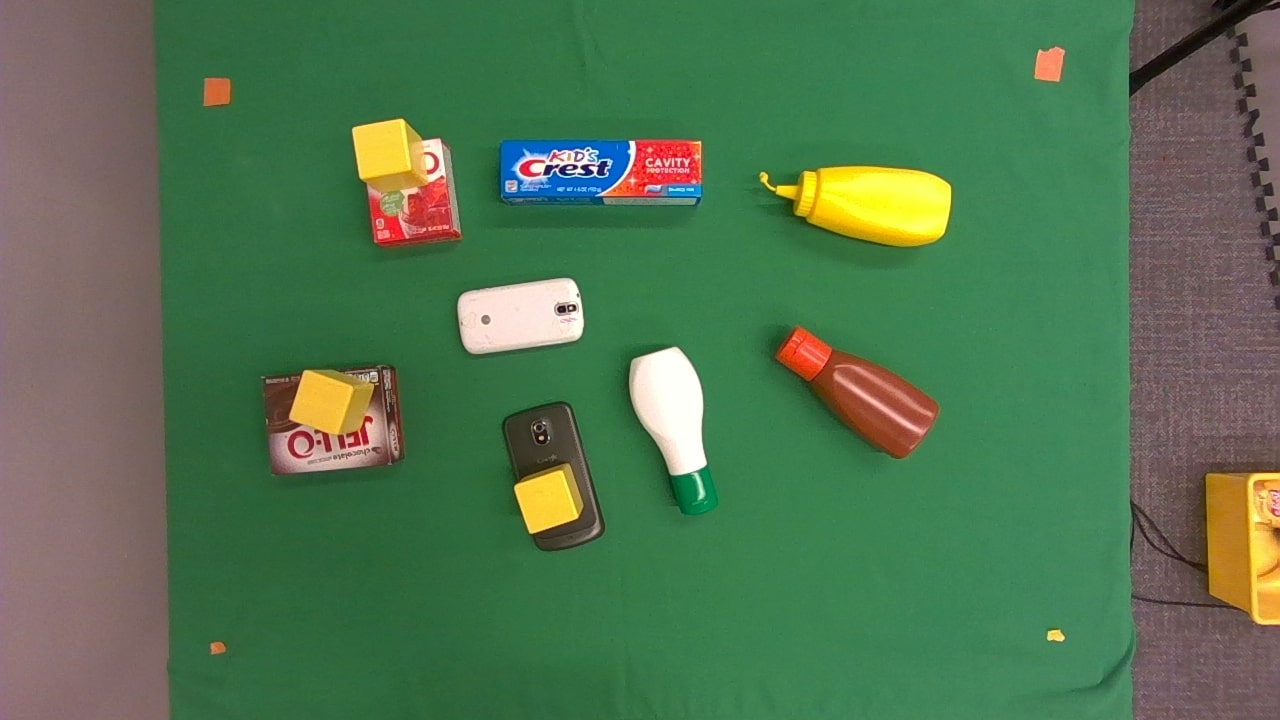

In [ ]:
local_image_path = "/content/Grounded-Segment-Anything/image-segmentation-and-analysis/RAM/images/demo/color_image.jpg"
image_source, image = load_image(local_image_path)
Image.fromarray(image_source)

## Grounding DINO for detection

In [ ]:
# detect object using grounding DINO
def detect(image, text_prompt, model, box_threshold = 0.3, text_threshold = 0.25):
  boxes, logits, phrases = predict(
      model=model,
      image=image,
      caption=text_prompt,
      box_threshold=box_threshold,
      text_threshold=text_threshold
  )

  annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
  annotated_frame = annotated_frame[...,::-1] # BGR to RGB
  return annotated_frame, boxes

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


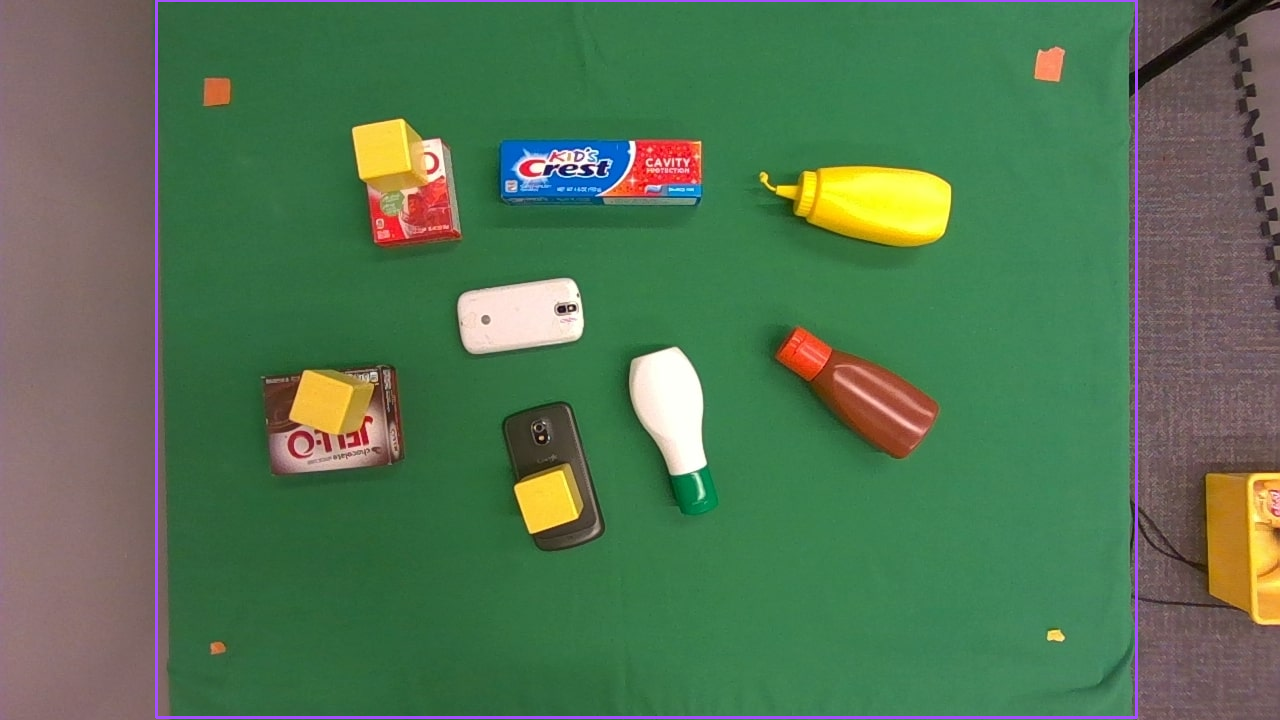

In [ ]:
annotated_frame, detected_boxes = detect(image, text_prompt="table", model=groundingdino_model)
Image.fromarray(annotated_frame)

## SAM for segmentation

In [ ]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()


def draw_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

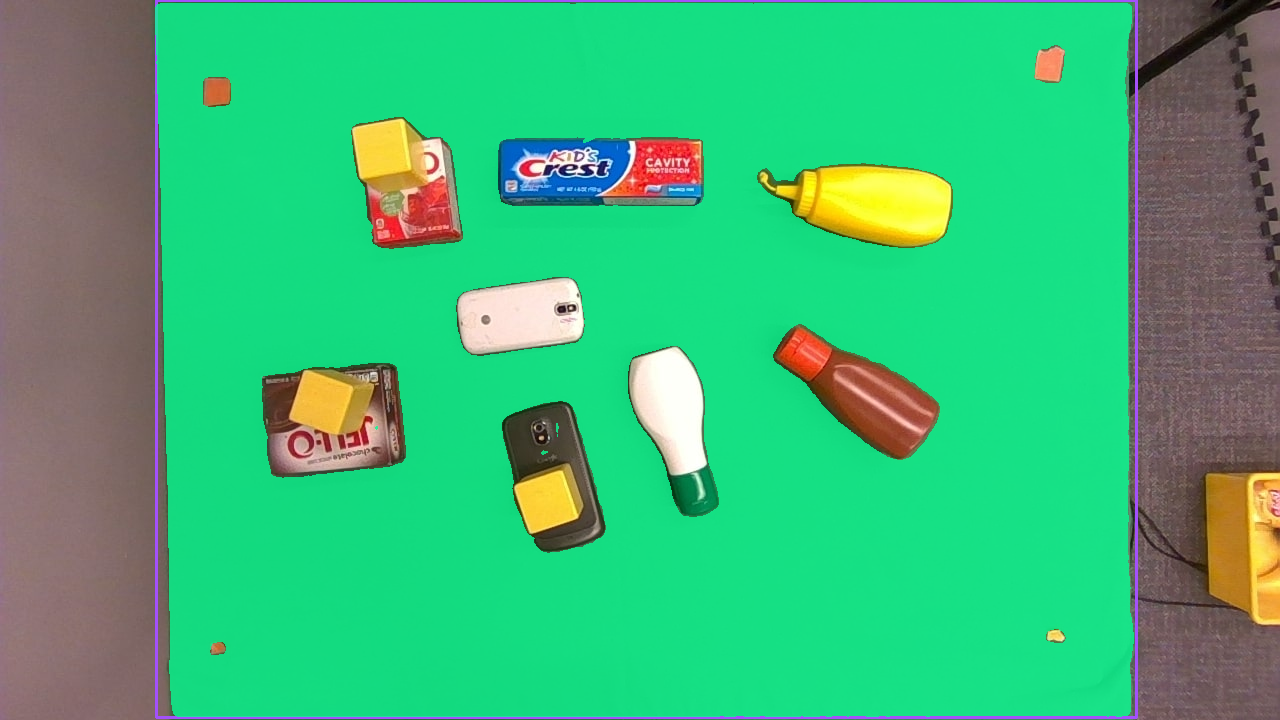

In [ ]:
segmented_frame_masks = segment(image_source, sam_predictor, boxes=detected_boxes)
annotated_frame_with_mask = draw_mask(segmented_frame_masks[0][0], annotated_frame)
Image.fromarray(annotated_frame_with_mask)

## Stable Diffusion for inpainting

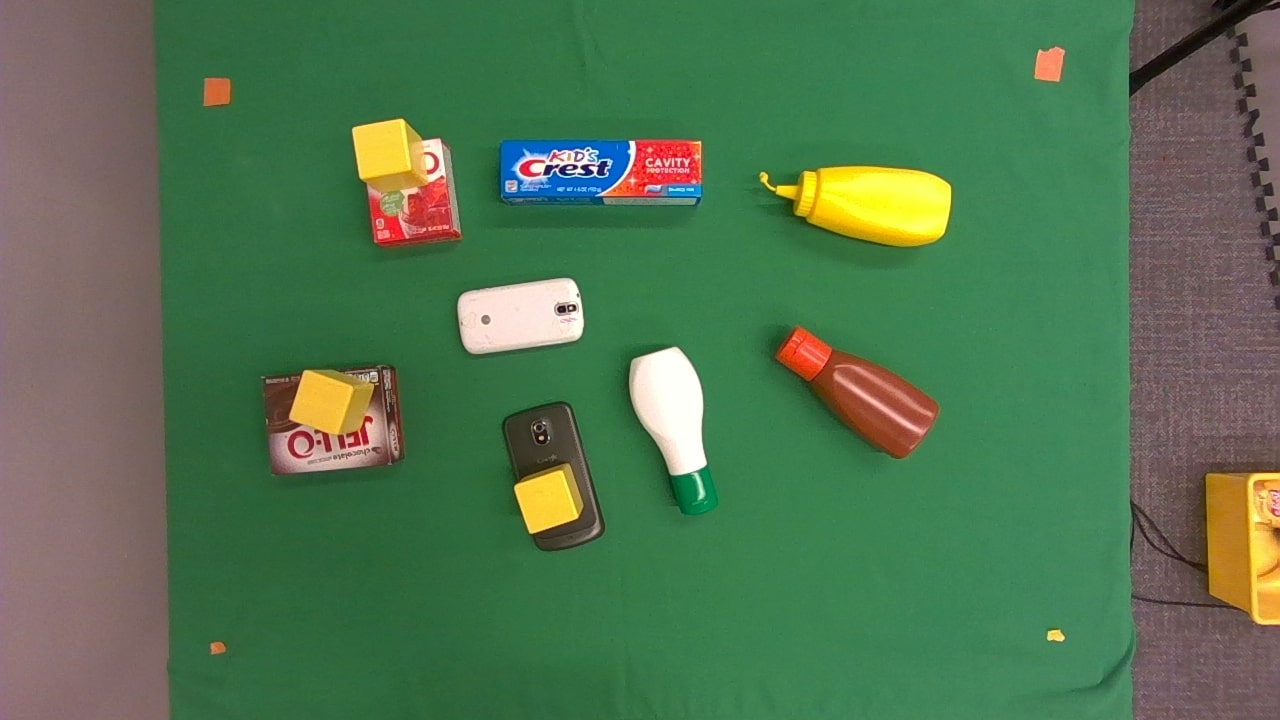

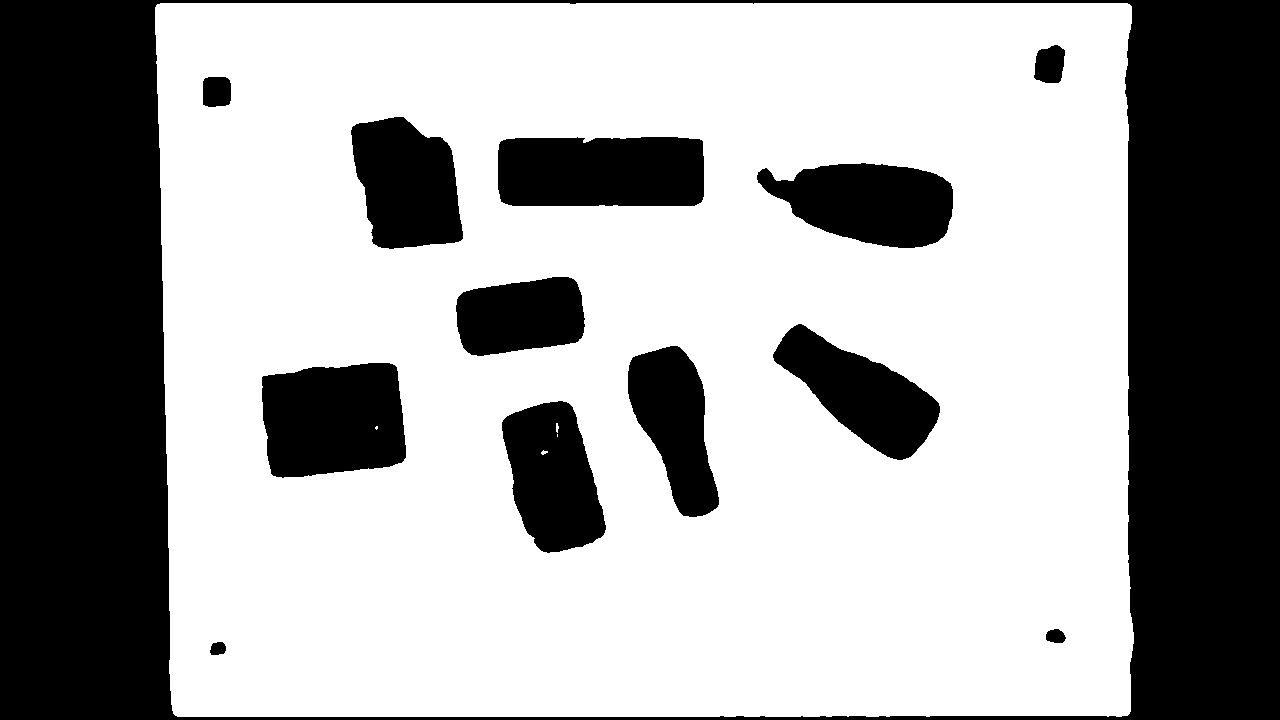

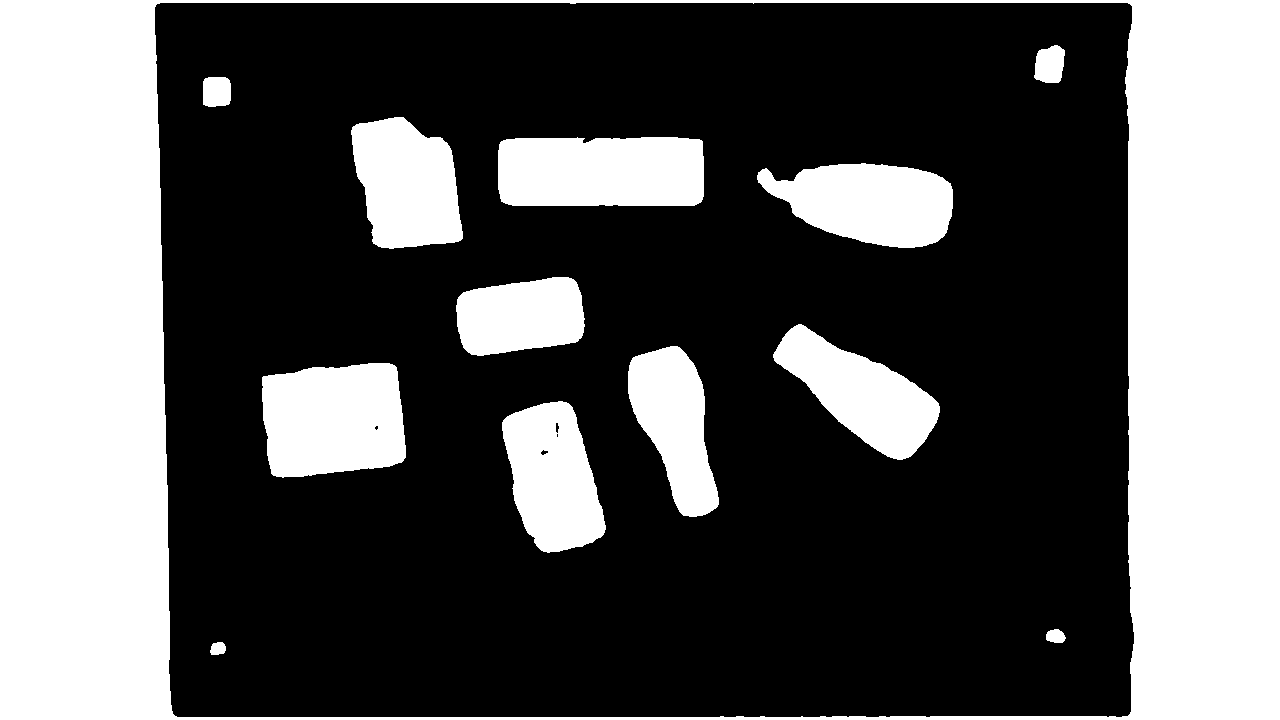

In [ ]:
# create mask images
mask = segmented_frame_masks[0][0].cpu().numpy()
inverted_mask = ((1 - mask) * 255).astype(np.uint8)


image_source_pil = Image.fromarray(image_source)
image_mask_pil = Image.fromarray(mask)
inverted_image_mask_pil = Image.fromarray(inverted_mask)


display(*[image_source_pil, image_mask_pil, inverted_image_mask_pil])

In [ ]:
def generate_image(image, mask, prompt, negative_prompt, pipe, seed):
  # resize for inpainting
  w, h = image.size
  in_image = image.resize((512, 512))
  in_mask = mask.resize((512, 512))

  generator = torch.Generator(device).manual_seed(seed)

  result = pipe(image=in_image, mask_image=in_mask, prompt=prompt, negative_prompt=negative_prompt, generator=generator)
  result = result.images[0]

  return result.resize((w, h))

In [ ]:
prompt="A table, high quality, red"
negative_prompt="low resolution, ugly"
seed = 32 # for reproducibility

generated_image = generate_image(image=image_source_pil, mask=image_mask_pil, prompt=prompt, negative_prompt=negative_prompt, pipe=sd_pipe, seed=seed)
generated_image

NameError: ignored

  0%|          | 0/50 [00:00<?, ?it/s]

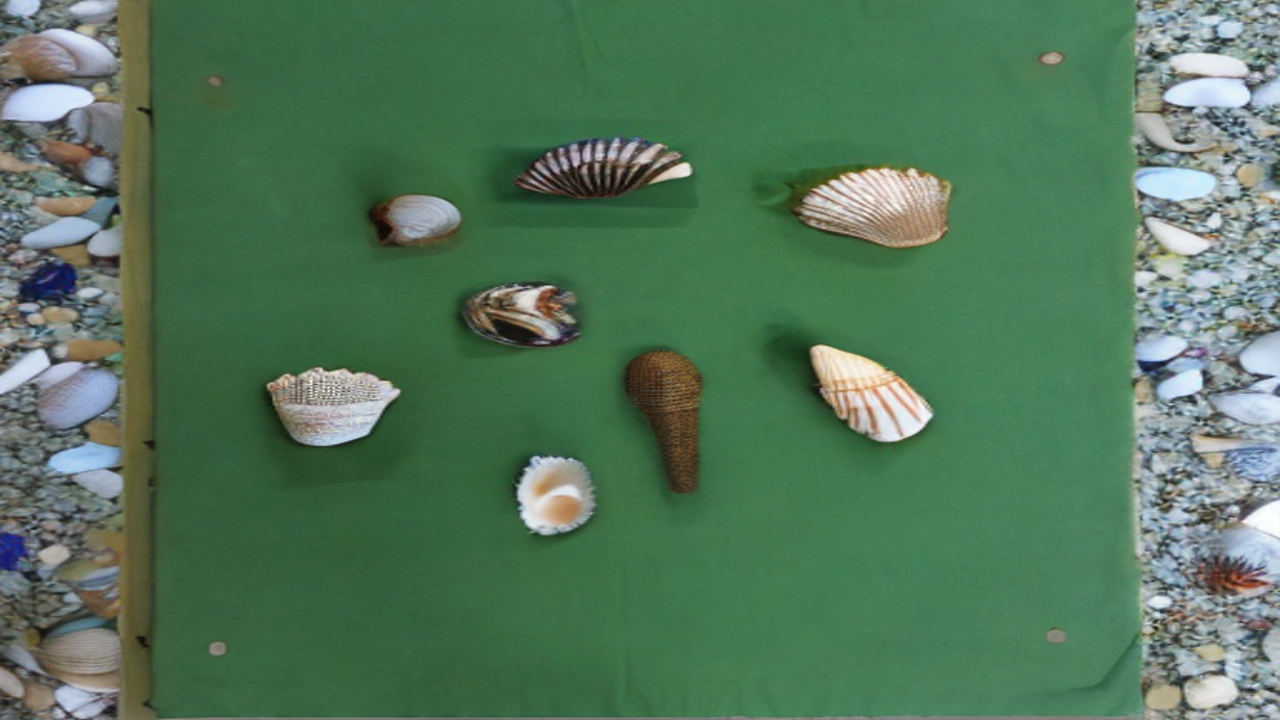

In [ ]:
prompt="a table, sand, seashells and coconuts"
negative_prompt="people, low resolution, ugly"
seed = 32 # for reproducibility

generated_image = generate_image(image_source_pil, inverted_image_mask_pil, prompt, negative_prompt, sd_pipe, seed)
generated_image